# Learning based methods

This is a model which takes a collection of images and figures out how to align them using an unsupervised approach. It is based on a paper by de Vos, Beredensen, Viergever, Sokooti, Staring, Isgum: [https://arxiv.org/pdf/1809.06130.pdf]().

In [1]:
import glob
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

config = tf.ConfigProto()
# config.gpu_options.allocator_type = 'BFC'
tf.Session(config = config)

C:\Users\TWright\Anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 183846903519456144
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3421679616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14006157777682604237
physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [2]:
def load_img_paths(target):
    '''
    Retrieve the full path of all images in the dataset
    '''
    return glob.glob(target + '/*.tif')

data_dir = r'../data'
original_data_dir = data_dir + ('/learning')
all_files = pd.DataFrame(load_img_paths(original_data_dir))
all_files = all_files[0].values.tolist()
all_files[:5]

['../data/learning\\Tp26_Y000_X000_040.tif',
 '../data/learning\\Tp26_Y000_X001_040.tif',
 '../data/learning\\Tp26_Y000_X002_040.tif',
 '../data/learning\\Tp26_Y000_X003_040.tif',
 '../data/learning\\Tp26_Y000_X004_040.tif']

In [3]:
train_paths = all_files

In [4]:
class NCC():
    """
    local (over window) normalized cross correlation
    """

    def __init__(self, win=None, eps=1e-5):
        self.win = win
        self.eps = eps


    def ncc(self, I, J):
        # get dimension of volume
        # assumes I, J are sized [batch_size, *vol_shape, nb_feats]
        ndims = len(I.get_shape().as_list()) - 2
        assert ndims in [1, 2, 3], "volumes should be 1 to 3 dimensions. found: %d" % ndims

        # set window size
        if self.win is None:
            self.win = [9] * ndims

        # get convolution function
        conv_fn = getattr(tf.nn, 'conv%dd' % ndims)

        # compute CC squares
        I2 = I*I
        J2 = J*J
        IJ = I*J

        # compute filters
        sum_filt = tf.ones([*self.win, 1, 1])
        strides = [1] * (ndims + 2)
        padding = 'SAME'

        # compute local sums via convolution
        I_sum = conv_fn(I, sum_filt, strides, padding)
        J_sum = conv_fn(J, sum_filt, strides, padding)
        I2_sum = conv_fn(I2, sum_filt, strides, padding)
        J2_sum = conv_fn(J2, sum_filt, strides, padding)
        IJ_sum = conv_fn(IJ, sum_filt, strides, padding)

        # compute cross correlation
        win_size = np.prod(self.win)
        u_I = I_sum/win_size
        u_J = J_sum/win_size

        cross = IJ_sum - u_J*I_sum - u_I*J_sum + u_I*u_J*win_size
        I_var = I2_sum - 2 * u_I * I_sum + u_I*u_I*win_size
        J_var = J2_sum - 2 * u_J * J_sum + u_J*u_J*win_size

        cc = cross*cross / (I_var*J_var + self.eps)

        # return negative cc.
        return tf.reduce_mean(cc)

    def loss(self, I, J):
        return - self.ncc(I, J)

## Network

> A ConvNet design for affine image registration. The network analyzes pairs of fixed and moving images in separate pipelines. Ending each pipeline with global average pooling enables analysis of input images of different sizes, and allows concatenation with the fully connected layers that have a fixed number of nodes connected to 12 affne transformation parameter outputs.

> The two separate pipelines analyze input pairs of fixed and moving images and each consist of five alternating 3x3x3 convolution layers and 2x2x2 downsampling layers. The number of these layers may vary, depending on task complexity and input image size. The weights of the layers are shared between the two pipelines to limit the number of total parameters in the network.

> The Conv-Nets were initialized with Glorot's uniform distribution (Glorot and Bengio, 2010) and optimized with Adam.

> Subsequently, the network can be connected to a neural network work that will decode the relative orientations of the fixed and moving images and convert those to 12 affine transformation parameters: *three translation*, *three rotation*, *three scaling*, and *three shearing parameters*.

2D images -> Two translation, `x,y`, one rotation `theta`, one scaling `s`, two shearing `gx, gy` = 6 parameters

In [28]:
from keras.layers.core import Dense
from keras.layers.convolutional import Convolution2D
from keras.layers import Input, Conv2D, AveragePooling2D, GlobalAveragePooling2D, concatenate, Reshape
from keras.models import Sequential, Model

from m_stn import BilinearInterpolation

def get_initial_weights(output_size):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((output_size, 6), dtype='float32')
    weights = [W, b.flatten()]
    return weights

def dlir_layer(m1, m2, filters):
    '''
    alternating 3x3 convolution layers and 2x2 downsampling layers
    '''
    conv= Conv2D(filters, (3,3), activation='relu', padding='same')
    avg = AveragePooling2D() # default size is 2x2
    return avg(conv(m1)), avg(conv(m2))
    
def affine_pipeline(input_shape):
    '''
    five alternating 3x3 convolution layers and 2x2 downsampling layers
    Ending each pipeline with global average pooling
    '''
    filters = 32
    in1 = Input(shape=input_shape, name='moving_input')
    in2 = Input(shape=input_shape, name='reference_input')
    m1, m2 = dlir_layer(in1, in2, filters)
    m1, m2 = dlir_layer(m1, m2, filters)
    m1, m2 = dlir_layer(m1, m2, filters)
    m1, m2 = dlir_layer(m1, m2, filters)
    
    conv = Conv2D(filters, (3,3), activation='relu', padding='same')
    glob_avg = GlobalAveragePooling2D()
    
    return in1, in2, glob_avg(conv(m1)), glob_avg(conv(m2))
    
def my_DLIR(input_shape):
    '''
    Implement DLIR architecture
    '''
    input_1, input_2, moving_pipeline, reference_pipeline = affine_pipeline(input_shape)
    
    cat = concatenate([moving_pipeline, reference_pipeline])
    cat = Dense(2048, activation='relu')(cat)
    affine_transform = Dense(6, activation='linear', weights=get_initial_weights(2048), name='affine_params')(cat)
    
    image_output = BilinearInterpolation(input_shape[:-1])([input_2, affine_transform])
    return Model(inputs=[input_1, input_2], outputs=[image_output])


In [29]:
from keras.optimizers import Adam
from skimage.io import imread

def aspect_resize(newsize, shape):
    '''
    Given an integer and a shape, return a tuple with the longest side of the shape = newsize
    '''
    m = np.argmax(shape)
    if m == 0:
        return (newsize, int(shape[1] / (shape[0] / newsize)))
    return (int(shape[0] / (shape[1] / newsize)), newsize, 1)

orig_shape = imread(all_files[0]).shape
img_size = aspect_resize(256, orig_shape)

my_model = my_DLIR(img_size)
# my_model.compile(loss=NCC().loss, optimizer=Adam(lr=1e-4))
my_model.compile(loss='mse', optimizer=Adam(lr=1e-4))
my_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
reference_input (InputLayer)    (None, 195, 256, 1)  0                                            
__________________________________________________________________________________________________
moving_input (InputLayer)       (None, 195, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 195, 256, 32) 320         moving_input[0][0]               
                                                                 reference_input[0][0]            
__________________________________________________________________________________________________
average_pooling2d_13 (AveragePo (None, 97, 128, 32)  0           conv2d_16[0][0]                  
          

In [30]:
from os import path
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import Sequence
from skimage.transform import resize

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
def image_pair_coords(fname, ymin=0, ymax=7, xmin=0, xmax=14):
    '''
    get an image's pair.
    '''
    im_coords = path.split(fname)[-1] \
                        .split('.')[0]    \
                        .split('_')[1:3]
    y_part = int(im_coords[0].split('Y')[1])
    x_part = int(im_coords[1].split('X')[1])
    if y_part == ymin:
        y_part = ymin+1
    elif y_part == ymax:
        y_part = ymax-1
    else:
        y_part  = y_part+1 if np.random.random() > 0.5 else y_part-1

    if x_part == xmin:
        x_part = xmin+1
    elif x_part == xmax:
        x_part = xmax-1
    else:
        x_part = x_part+1 if np.random.random() > 0.5 else x_part-1

    ystr = str(y_part).rjust(2,'0')
    xstr = str(x_part).rjust(2,'0')
    fpath = path.split(fname)[:-1][0]
    next_fname = path.join(fpath, 'Tp26_Y0%s_X0%s_040.tif' % (ystr, xstr))
    return next_fname       
        
class DataGenerator(Sequence):
    '''
    Adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html
    Allows for multiprocessing in the fit generator
    '''

    def __init__(self, train_set, val_set, batch_size, im_size):
        self.train, self.val = train_set, val_set
        self.batch_size = batch_size
        self.im_size = im_size

    def __len__(self):
        return int(np.ceil(len(self.train) / float(self.batch_size)))

    # Will output sequence of tuples (image, test) given a datapath
    def __getitem__(self, idx):
        X1 = np.zeros(shape=(batch_size, self.im_size[0], self.im_size[1], 1))
        X2 = np.zeros(shape=(batch_size, self.im_size[0], self.im_size[1], 1))
        y  = np.zeros(shape=(batch_size, self.im_size[0], self.im_size[1], 1))
        batch = self.train[idx * self.batch_size:(idx + 1) * self.batch_size]
        for j,fname in enumerate(batch):
            # to speed this up preprocess the images so they aren't resized on the fly
            X1[j] = img_to_array(load_img(fname, target_size=self.im_size, grayscale=True))
            fname_moving = image_pair_coords(fname)
            X2[j] = img_to_array(load_img(fname_moving, target_size=self.im_size, grayscale=True))
            y[j] = X1[j]
        return ([X1, X2], y)

    
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# create weights file if it doesn't exist for ModelCheckpoint
from os import mkdir
try: 
    mkdir('tmp')
except FileExistsError:
    print('tmp directory already exists')

# history function
history = LossHistory()

tmp directory already exists


In [31]:
batch_size = 8
epochs     = 32
steps_per_epoch  = int(len(train_paths) / batch_size)
training_generator = DataGenerator(train_paths, [], batch_size, img_size)

# descriptive weight file naming
checkpointer = ModelCheckpoint(filepath=('tmp/weights-%d-%d.hdf5' % 
                                         (batch_size, img_size[0])), 
                               verbose=1, save_best_only=True)

hist = my_model.fit_generator(training_generator,
    epochs=epochs,
    workers=3,
    verbose=2,
    callbacks=[history, checkpointer, early_stopping]
)

Epoch 1/32
 - 4s - loss: 7278.2522
Epoch 2/32


C:\Users\TWright\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\callbacks.py:435: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
C:\Users\TWright\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\callbacks.py:526: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 1s - loss: 21627.5863
Epoch 3/32
 - 1s - loss: 34034.5208
Epoch 4/32
 - 1s - loss: 35192.3602
Epoch 5/32
 - 1s - loss: 35192.3604
Epoch 6/32
 - 1s - loss: 35192.3602
Epoch 7/32
 - 1s - loss: 35192.3615
Epoch 8/32
 - 1s - loss: 35192.3612
Epoch 9/32
 - 1s - loss: 35192.3604
Epoch 10/32
 - 1s - loss: 35192.3599
Epoch 11/32
 - 1s - loss: 35192.3607
Epoch 12/32
 - 1s - loss: 35192.3594
Epoch 13/32
 - 1s - loss: 35192.3615
Epoch 14/32
 - 1s - loss: 35192.3604
Epoch 15/32
 - 1s - loss: 35192.3607
Epoch 16/32
 - 1s - loss: 35192.3607
Epoch 17/32
 - 1s - loss: 35192.3609
Epoch 18/32
 - 1s - loss: 35192.3607
Epoch 19/32
 - 1s - loss: 35192.3596
Epoch 20/32
 - 1s - loss: 35192.3609
Epoch 21/32
 - 1s - loss: 35192.3604
Epoch 22/32
 - 1s - loss: 35192.3615
Epoch 23/32
 - 1s - loss: 35192.3602
Epoch 24/32
 - 1s - loss: 35192.3604
Epoch 25/32
 - 1s - loss: 35192.3607
Epoch 26/32
 - 1s - loss: 35192.3607
Epoch 27/32
 - 1s - loss: 35192.3604
Epoch 28/32
 - 1s - loss: 35192.3604
Epoch 29/32
 - 1s - 

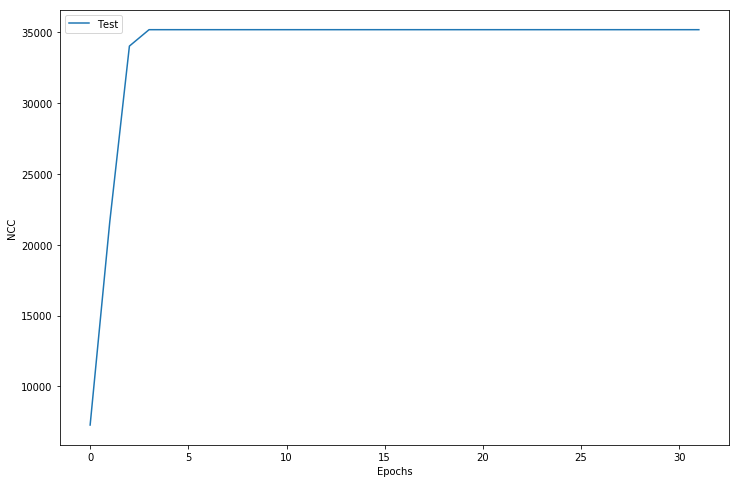

In [32]:
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.plot(hist.epoch,hist.history['loss'], label='Test')
# plt.plot(hist.epoch,hist.history['val_loss'],label='Validation',linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('NCC')
plt.legend()
plt.show()

In [33]:
im1 = resize(imread(all_files[1]), img_size)
im2 = resize(imread(all_files[2]), img_size)
im1 = im1.reshape(-1, *img_size)
im2 = im2.reshape(-1, *img_size)
im3 = my_model.predict([im1, im2])

C:\Users\TWright\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Tensor("affine_params/BiasAdd:0", shape=(?, 6), dtype=float32)


In [37]:
# 
intermediate_model = Model(inputs=[my_model.get_layer('reference_input').input, 
                                   my_model.get_layer('moving_input').input], 
                           outputs=[my_model.get_layer('affine_params').output])
intermediate_model.predict([im1, im2])[0].reshape(2,3)

array([[ 0.99488765,  0.0023994 ,  0.01330745],
       [-0.00423812,  0.9969763 ,  0.00108849]], dtype=float32)

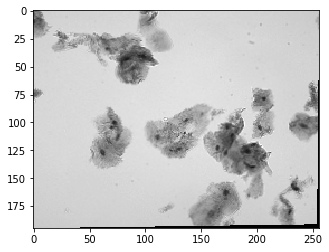

In [20]:
import matplotlib.pyplot as plt
plt.imshow(im3[0][:,:,-1], cmap='gray')
plt.show()